In [3]:
import datetime

import numpy as np
import matplotlib.pyplot as plt

from functools import lru_cache
from abc import ABC, abstractmethod

class RouletteSimulation(ABC):
    def __init__(self, starting_balance, winning_chance,start_bet, win_multiplier, samples):
        self.starting_balance = starting_balance
        self.winning_chance = winning_chance # Desc
        self.start_bet = start_bet
        self.win_multiplier = win_multiplier
        self.samples = samples

        self.results = None
        self.bets = None
        self.balances = None

        self.current_game = 0

    def game_results(self):
        return np.random.choice(a=[True, False], size=self.samples, p=[self.winning_chance, 1 - self.winning_chance])


    def next_game(self):
        if self.current_game == 0:
                self.balances = np.full(self.samples, self.starting_balance, dtype=np.int64)
                self.bets = self.first_bets()
                self.balances -= self.bets
                self.results = self.game_results()
        else:
            self.balances = np.where(self.results, self.balance_after_win(), self.balances)
            self.bets = np.where(self.results, self.bets_after_win(), self.bets_after_lose())
            self.balances -= self.bets
            self.results = self.game_results()
        self.current_game += 1

    def __repr__(self):
        summary = f"balances: {self.balances}\nbets: {self.bets}\nresults: {self.results}\n"
        return summary

    def first_bets(self):
        return np.full(self.samples, self.start_bet, dtype=np.int64)

    @abstractmethod
    def bets_after_win(self):
        pass
    @abstractmethod
    def bets_after_lose(self):
        pass

    def balance_after_win(self):
        return self.balances + self.bets * self.win_multiplier


class Martingale(RouletteSimulation):
    def __init__(self, starting_balance, winning_chance,start_bet, win_multiplier, samples):
        super().__init__(starting_balance=starting_balance, winning_chance=winning_chance, start_bet=start_bet, win_multiplier=win_multiplier, samples=samples)

    def bets_after_win(self):
        return self.first_bets()

    def bets_after_lose(self):
        return self.bets * 2

class Fibonacci(RouletteSimulation):
    def __init__(self, starting_balance, winning_chance,start_bet, win_multiplier, samples):
        super().__init__(starting_balance=starting_balance, winning_chance=winning_chance, start_bet=start_bet, win_multiplier=win_multiplier, samples=samples)

        self.minimum_fib = 1
        self.fib_n = np.full(samples, self.minimum_fib) # Based on fib.results

    @lru_cache(maxsize=None)
    def fib(self, n):
        # 0 1 2 3     <- n
        # 1 1 2 3 ... <- return values
        if n < 2:
            return 1
        return self.fib(n - 2) + self.fib(n - 1)

    def fib_fill(self, fib_n: np.ndarray):
        return np.vectorize(self.fib)(fib_n)

    def next_game(self):
        super().next_game()
        self.fib_n = np.where(self.results, self.fib_n - 2, self.fib_n + 1)
        self.fib_n = np.where(self.fib_n < self.minimum_fib, self.minimum_fib, self.fib_n)

    def bets_after_win(self):
        return self.fib_fill(self.fib_n)

    def bets_after_lose(self):
        return self.fib_fill(self.fib_n)

## Experiment

In [4]:
def simulate(simulation: RouletteSimulation, games_number):
    cpu_frequency = 1_000_000_000
    print(f"Simulation should take around: {simulation.samples * games_number / cpu_frequency}s")

    means = np.empty(games_number)
    for game in range(games_number):
        simulation.next_game()
        means[game] = simulation.balances.mean()
    return means

In [5]:
### 1 % fee unlimited money

## Martingale

In [6]:
martingale = Martingale(starting_balance=1_000,
                        winning_chance = 0.5,
                        start_bet=1,
                        win_multiplier=2,
                        samples=3,
)
print(martingale)
for _ in range(3):
    martingale.next_game()
    print(martingale)

balances: None
bets: None
results: None

balances: [999 999 999]
bets: [1 1 1]
results: [ True False False]

balances: [1000  997  997]
bets: [1 2 2]
results: [False False False]

balances: [998 993 993]
bets: [2 4 4]
results: [ True  True False]



 ## Fibonacci

In [7]:
fibonacci = Fibonacci(starting_balance=10_000_000,
                        winning_chance = 0.5,
                        start_bet=1,
                        win_multiplier=2,
                        samples=3,
)
print(fibonacci)
for _ in range(3):
    fibonacci.next_game()
    print(fibonacci)

balances: None
bets: None
results: None

balances: [9999999 9999999 9999999]
bets: [1 1 1]
results: [False  True False]

balances: [ 9999997 10000000  9999997]
bets: [2 1 2]
results: [False False  True]

balances: [ 9999994  9999998 10000000]
bets: [3 2 1]
results: [ True  True False]



In [8]:
import matplotlib

def create_plots():
    martingale_50 = Martingale(starting_balance=STARTING_BALANCE,
                            winning_chance = 0.5,
                            start_bet=START_BET,
                            win_multiplier=WIN_MULTIPLIER,
                            samples=SAMPLES
    )
    martingale_45 = Martingale(starting_balance=STARTING_BALANCE,
                            winning_chance = 0.45,
                            start_bet=START_BET,
                            win_multiplier=WIN_MULTIPLIER,
                            samples=SAMPLES
    )


    fibonacci_50 = Fibonacci(starting_balance=STARTING_BALANCE,
                            winning_chance = 0.5,
                            start_bet=START_BET,
                            win_multiplier=WIN_MULTIPLIER,
                            samples=SAMPLES
    )
    fibonacci_45 = Fibonacci(starting_balance=STARTING_BALANCE,
                            winning_chance = 0.45,
                            start_bet=START_BET,
                            win_multiplier=WIN_MULTIPLIER,
                            samples=SAMPLES
    )
    martingale_50_result = simulate(martingale_50, games_number=GAMES)
    martingale_45_result = simulate(martingale_45, games_number=GAMES)
    fibonacci_50_result = simulate(fibonacci_50, games_number=GAMES)
    fibonacci_45_result = simulate(fibonacci_45, games_number=GAMES)

    props = {
        "xlabel": "game",
        "ylabel": "mean balance [$]",
        "xticks": [0, GAMES // 4, GAMES // 2, int(GAMES * 3/4), GAMES],
        "yticks": [0, STARTING_BALANCE, 2 * STARTING_BALANCE],
        "yscale": "log"
    }
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 15}

    matplotlib.rc('font', **font)

    plt.style.use('dark_background')

    fig, plots = plt.subplots(2, 2, figsize=[15, 10])
    (martingale_50_plot, martingale_45_plot), (fibonacci_50_plot, fibonacci_45_plot) = plots

    for single_plot, results, plot_title in zip([martingale_50_plot, martingale_45_plot, fibonacci_50_plot, fibonacci_45_plot],
                                    [martingale_50_result, martingale_45_result, fibonacci_50_result, fibonacci_45_result],
                                    ["Martingale 50% chance of winning", "Martingale 45% chance of winning", "Fibonacci 50% chance of winning", "Fibonacci 45% chance of winning"]
                                    ):
        print(plot_title)
        single_plot.plot(results)
        single_plot.set(**props)
        single_plot.set_title(plot_title)

    plt.subplots_adjust(hspace=0.5)

    plt.savefig(f"./plots/results{datetime.date.today()}.jpg")

Simulation should take around: 0.01s
Simulation should take around: 0.01s
Simulation should take around: 0.01s
Simulation should take around: 0.01s


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Martingale 50% chance of winning
Martingale 45% chance of winning
Fibonacci 50% chance of winning
Fibonacci 45% chance of winning


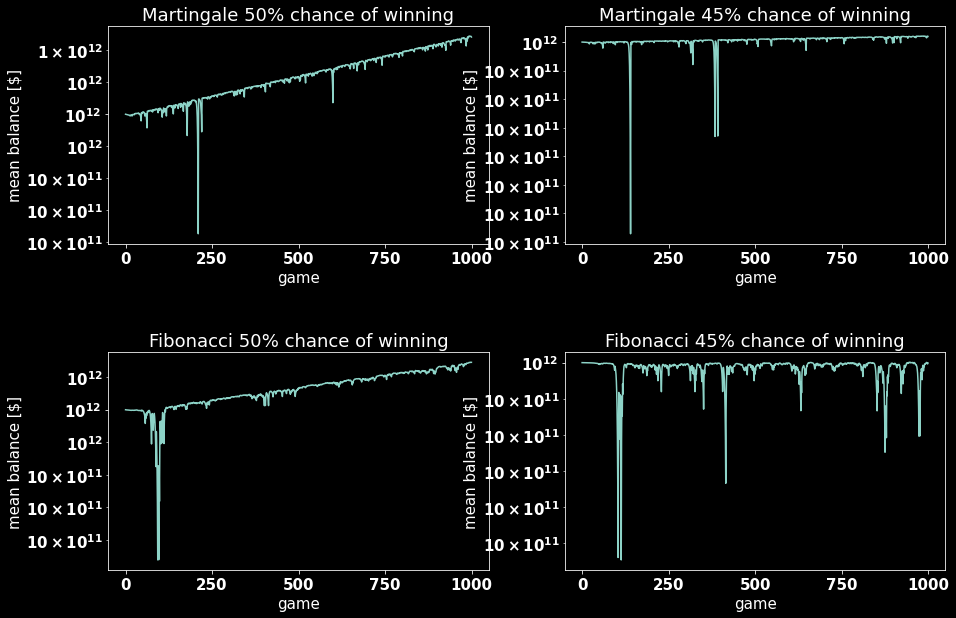

In [9]:
STARTING_BALANCE = 1_000_000_000_000
START_BET = 1
WIN_MULTIPLIER = 2

GAMES = 1_000
SAMPLES = 10_000
create_plots()